## 전처리 및 데이터 준비

In [ ]:
!unzip "./drive/MyDrive/dataset/근골격계/TS2_DOG.zip" -d ./TS2_DOG
!unzip "./drive/MyDrive/dataset/근골격계/valid/VS2_DOG.zip" -d ./VS2_DOG

In [ ]:
!mkdir ./dataset

!mkdir ./dataset/images
!mkdir ./dataset/images/NOR
!mkdir ./dataset/images/Mu05
!mkdir ./dataset/images/Mu06
!mkdir ./dataset/images/Mu07

!mkdir ./test_images
!mkdir ./test_images/NOR
!mkdir ./test_images/Mu05
!mkdir ./test_images/Mu06
!mkdir ./test_images/Mu07

In [ ]:
import shutil
import os
path = "./TS2_DOG/"
destination = "./dataset/images/"
for i in os.listdir(path):
    if "Mu05" not in i and "Mu06" not in i and "Mu07" not in i:
        continue
    if "NOR" in i:
        shutil.copy(path+i, destination +"NOR/"+ i)
    elif "ABN" in i:
        if "Mu05" in i:
            shutil.copy(path+i, destination +"Mu05/"+ i)
        elif "Mu06" in i:
            shutil.copy(path+i, destination +"Mu06/"+ i)
        elif "Mu07" in i:
            shutil.copy(path+i, destination +"Mu07/"+ i)

In [ ]:
import shutil
import os
path = "./VS2_DOG/"
destination = "./test_images/"
for i in os.listdir(path):
    if "Mu05" not in i and "Mu06" not in i and "Mu07" not in i:
        continue
    if "NOR" in i:
        shutil.copy(path+i, destination +"NOR/"+ i)
    elif "ABN" in i:
        if "Mu05" in i:
            shutil.copy(path+i, destination +"Mu05/"+ i)
        elif "Mu06" in i:
            shutil.copy(path+i, destination +"Mu06/"+ i)
        elif "Mu07" in i:
            shutil.copy(path+i, destination +"Mu07/"+ i)

In [ ]:
import random
# 정상 Xray가 너무 많아서 언더샘플링 진행
path = "./dataset/images/NOR/"
count = 0
list_nor = os.listdir(path)
random.shuffle(list_nor)
for i in list_nor:
    if count == 19000:
        break
    os.remove(path + i)
    count += 1

In [ ]:
len(os.listdir("./dataset/images/NOR")), len(os.listdir("./dataset/images/Mu05")), len(os.listdir("./dataset/images/Mu06")), len(os.listdir("./dataset/images/Mu07"))

(2871, 2537, 1030, 1015)

In [ ]:
import tensorflow as tf
import numpy as np
from collections import Counter

data_augmentation = tf.keras.Sequential([
    # 랜덤 회전 (-10도 ~ 10도)
    tf.keras.layers.RandomRotation(factor=0.04321),
    # 랜덤 가로, 세로 이동 (최대 10% 이동)
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    # 랜덤 좌우 뒤집기
    tf.keras.layers.RandomFlip(mode="horizontal"),
    # 랜덤 줌 인/아웃 (줌 범위: -10% ~ +10%)
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))
])

train_ds  = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/images",
    labels="inferred", # 클래스 이름 폴더 기반 자동 추론
    label_mode="categorical", # 정상/Mu05/Mu06/Mu07 4가지 클래스
    color_mode="grayscale", # Xray -> 흑백
    batch_size=32,
    image_size=(384, 384),
    shuffle=True,
    seed=42,
    validation_split=0.2, # 8 : 2 분리
    subset="training"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/images",
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=32,
    image_size=(384, 384),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("클래스 목록:", class_names)

In [ ]:
# 클래스별 샘플 수
class_counts = Counter()
for _, labels in train_ds: 
    class_indices = np.argmax(labels.numpy(), axis=1)
    class_counts.update(class_indices)
    
print("클래스별 샘플 수:", class_counts)

In [ ]:
# Class 가중치 계산
samples_per_class = np.array([class_counts[i] for i in range(num_classes)])
total_samples = np.sum(samples_per_class)
class_weights = total_samples / (samples_per_class * num_classes)
class_weight_dict = {i: class_weights[i] for i in range(num_classes)}
print("Class Weights:", class_weight_dict)

In [ ]:
# 학습 데이터만 증강
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# 모델 준비/학습

In [ ]:
# 정상/Mu05/Mu06 에서 가장 성능이 좋았던 모델 전이학습
base_model = tf.keras.models.load_model("./drive/MyDrive/models/근골격계/Mu05_Mu06 8506/Mu05_Mu06.keras")
base_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1046 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 384, 384, 3)         │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 12, 12, 2048)        │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,301,853 (672.54 MB)

 Trainable params: 58,717,833 (223.99 MB)

 Non-trainable params: 148,352 (579.50 KB)

 Optimizer params: 117,435,668 (447.98 MB)

In [ ]:
# 초기 학습에는 base_model의 가중치 고정
base_model.trainable = False 

inputs = tf.keras.Input(shape=(384, 384, 1)) 
x = base_model.layers[0](inputs)
x = base_model.layers[1](x) 
x = base_model.layers[2](x) 
x = base_model.layers[3](x) 
x = base_model.layers[4](x) 
x = base_model.layers[5](x) 
x = base_model.layers[6](x) 
x = base_model.layers[7](x) 
x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.BatchNormalization()(x)

# 기존 Dense(3) 대신 새로운 Dense(4) 적용
outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 384, 384, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 384, 384, 3)         │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 12, 12, 2048)        │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,933,258 (224.81 MB)

 Trainable params: 67,332 (263.02 KB)

 Non-trainable params: 58,865,926 (224.56 MB)

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=10000, alpha=1e-6)

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr_scheduler, momentum=0.9), # 확률적 경사 하강법 사용
    loss='categorical_crossentropy', # One-hot 인코딩 적용되었기 때문에 categorical_crossentropy 사용
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()] # Precision, Recall, AUC 등 다양한 지표 사용
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,         
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  
    batch_size=None,  
    callbacks=[early_stopping],
    class_weight=class_weight_dict # Class_Weight 적용
)

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 158s 697ms/step - accuracy: 0.4921 - auc_3: 0.7494 - loss: 3.7374 - precision_3: 0.5329 - recall_3: 0.4113 - val_accuracy: 0.7436 - val_auc_3: 0.9443 - val_loss: 2.9538 - val_precision_3: 0.7542 - val_recall_3: 0.7188
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 113s 605ms/step - accuracy: 0.7282 - auc_3: 0.9259 - loss: 2.9275 - precision_3: 0.7499 - recall_3: 0.6919 - val_accuracy: 0.7517 - val_auc_3: 0.9485 - val_loss: 2.7525 - val_precision_3: 0.7591 - val_recall_3: 0.7315
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 114s 606ms/step - accuracy: 0.7278 - auc_3: 0.9330 - loss: 2.7265 - precision_3: 0.7506 - recall_3: 0.6982 - val_accuracy: 0.7423 - val_auc_3: 0.9482 - val_loss: 2.5972 - val_precision_3: 0.7481 - val_recall_3: 0.7255
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 114s 608ms/step - accuracy: 0.7412 - auc_3: 0.9362 - loss: 2.5496 - precision_3: 0.7586 - recall_3: 0.7133 - val_accuracy: 0.7430 - val_auc_3: 0.9492 - val_loss: 2.4399 - val_precision_3

In [ ]:
model.layers[2].trainable = True # base_model 가중치 학습 활성화
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 384, 384, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 384, 384, 3)         │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 12, 12, 2048)        │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,000,591 (225.07 MB)

 Trainable params: 58,255,236 (222.23 MB)

 Non-trainable params: 678,022 (2.59 MB)

 Optimizer params: 67,333 (263.02 KB)

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=10000, alpha=1e-6)

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr_scheduler, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,         
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  
    batch_size=None,  
    callbacks=[early_stopping],
    class_weight=class_weight_dict # Class_Weight 적용
)

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 269s 989ms/step - accuracy: 0.7633 - auc_4: 0.9514 - loss: 0.7770 - precision_4: 0.7706 - recall_4: 0.7485 - val_accuracy: 0.7966 - val_auc_4: 0.9573 - val_loss: 0.7911 - val_precision_4: 0.7974 - val_recall_4: 0.7926
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 143s 762ms/step - accuracy: 0.7864 - auc_4: 0.9609 - loss: 0.6967 - precision_4: 0.7937 - recall_4: 0.7815 - val_accuracy: 0.8322 - val_auc_4: 0.9674 - val_loss: 0.7168 - val_precision_4: 0.8333 - val_recall_4: 0.8289
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 143s 760ms/step - accuracy: 0.8143 - auc_4: 0.9656 - loss: 0.6625 - precision_4: 0.8163 - recall_4: 0.8073 - val_accuracy: 0.8141 - val_auc_4: 0.9638 - val_loss: 0.7107 - val_precision_4: 0.8159 - val_recall_4: 0.8121
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 143s 760ms/step - accuracy: 0.8199 - auc_4: 0.9645 - loss: 0.6326 - precision_4: 0.8246 - recall_4: 0.8092 - val_accuracy: 0.8262 - val_auc_4: 0.9668 - val_loss: 0.6790 - val_precision_4

In [ ]:
model.save("Mu05_Mu07.keras")

## 모델 성능 확인

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model("./Mu05_Mu07.keras")

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./test_images",
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=32,
    image_size=(384, 384),
    shuffle=True,
    seed=42,
)

Found 6264 files belonging to 4 classes.


In [ ]:
results = model.evaluate(test_ds)

print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Precision: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")
print(f"AUC: {results[4]:.4f}")

196/196 ━━━━━━━━━━━━━━━━━━━━ 62s 248ms/step - accuracy: 0.7906 - auc_4: 0.9498 - loss: 0.7040 - precision_4: 0.7914 - recall_4: 0.7883
Loss: 0.7203
Accuracy: 0.7862
Precision: 0.7870
Recall: 0.7838
AUC: 0.9480


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

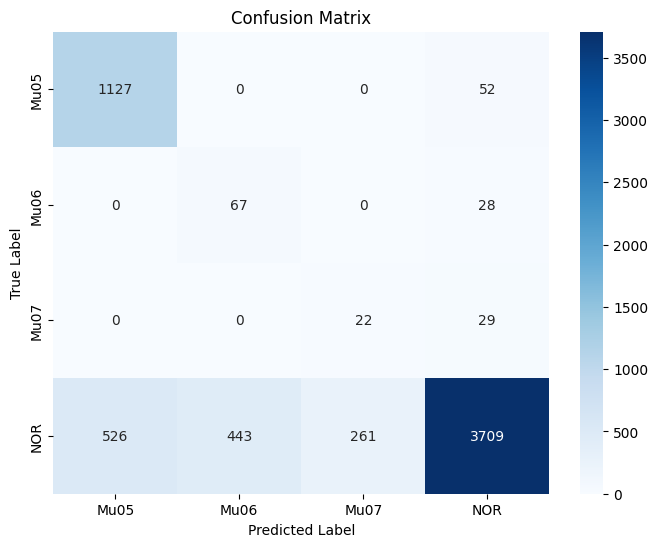

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 예측값과 실제값
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()